In [275]:
import matplotlib.pyplot as plt
import pymiediff as pmd
import torch
import numpy as np

In [276]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


# Custom optimiation loop example

### Define range of wavelegths to be incuded in optimation.

In [277]:
starting_wavelength = 200  # nm
ending_wavelength = 600  # nm

N_pt_test = 250

wl = torch.linspace(starting_wavelength, ending_wavelength, N_pt_test, dtype=torch.double)

k0 = (
    2 * torch.pi / wl
)

### Define preliminary vaules, starting gauesses or set paraemters. 

For this example lets say that core raduis is fixed to 12nm.

Lets polt the starting spretra as well.

In [278]:
core_radius = 12.0  # nm
shell_radius = 50.0  # nm
core_refractiveIndex = 2.0 + 0.1j
shell_refractiveIndex = 5.0 + 0.2j

Define what far-field spectra we are optimising, i.e. the forward model $f$:

In [279]:
optim_expression="q_sca"

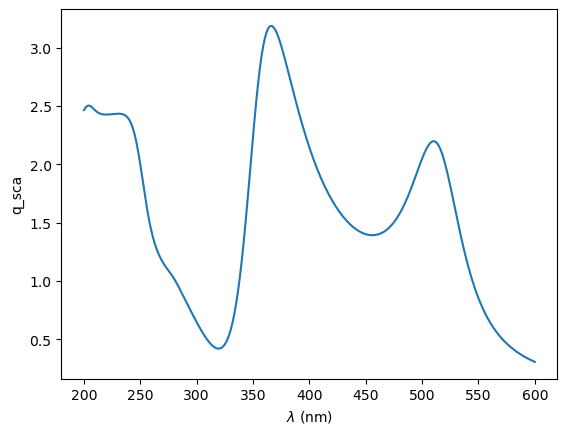

In [280]:
q_sca_start = pmd.farfield.cross_sections(
    k0=k0,
    r_c=core_radius,
    eps_c=core_refractiveIndex ** 2,
    r_s=shell_radius,
    eps_s=shell_refractiveIndex ** 2,
    eps_env=1,
    n_max=8,
)[optim_expression]

plt.plot(wl.detach(), q_sca_start.detach(), label = "Starting spetra.")
plt.xlabel("$\lambda$ (nm)")
plt.ylabel(optim_expression)
plt.show()

### Define target spectra.

We will target a gaussian scattering spetra centered at 350.0 um.

In [281]:
def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )

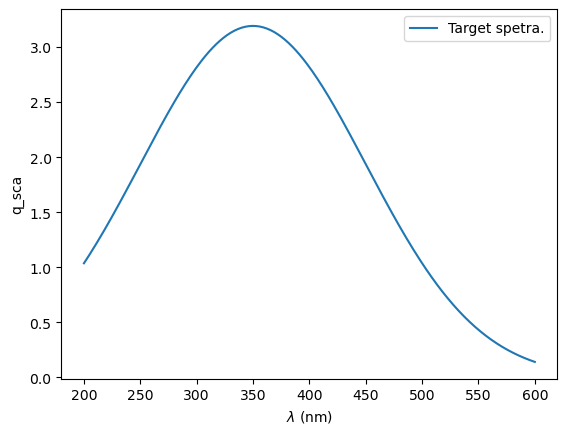

In [282]:
target = gaussian(wl.numpy(), 350.0, 100.0) * 800

plt.plot(wl, target, label = "Target spetra.")
plt.xlabel("$\lambda$ (nm)")
plt.ylabel(optim_expression)
plt.legend()
plt.show()

target = torch.tensor(target)


### Create parameter tensors $\Theta_j$. 

Note for all but the shell raduis (which is fixed) we set `requires_grad` to True.

In [283]:
r_c = torch.tensor(core_radius, requires_grad=False) # As we dont wish to optimise this

r_s = torch.tensor(shell_radius, requires_grad=True)
n_c = torch.tensor(core_refractiveIndex, requires_grad=True)
n_s = torch.tensor(shell_refractiveIndex, requires_grad=True)

### Optimisation Loop.

We must let the optimiser what parameters we arte optimising, i.e. Exclude `r_c`.

Within this loop we are iteritivly finding the optimal parameters $\Theta_{j+1}$, we must minimise the loss function $\mathcal{L}$, in which way to adjust the parameteers is determided by the optimiser, in this case we choose the `Adam` optimister. The loss function herew is the mean-squared error between the target spectra and the current spectra found through the forward model, 
$$
\mathcal{L}(\Theta_j)=\frac{1}{n} \sum_{i=1}^{n}\left(target_{i}-f(\Theta_j)_{i}\right)^{2}.
$$

To limit the refractive index of the core and shell to be physical ($> 0$) we create a secound loss term defined as:

$$
\mathcal{L}_{refract}= \frac{0.01}{\operatorname{Re}\left\{n_c\right\}} + \frac{0.01}{\operatorname{Re}\left\{n_s\right\}}.
$$

This approch can be used to limit other parameters.


In [284]:
import torch
import time

t0 = time.time()
optimizer = torch.optim.LBFGS([r_s, n_c, n_s], lr=0.9, max_iter=5, history_size=7) # LBFGS-specific params

max_iter = 20
losses = []  # Array to store loss data

def closure():
    optimizer.zero_grad()  # Reset gradients

    args = (k0, r_c, n_c**2, r_s, n_s**2)

    penalty_loss = 0.01 / n_c.real + 0.01 / n_c.real

    iteration_n = pmd.farfield.cross_sections(*args)[optim_expression]
    loss = torch.nn.functional.mse_loss(target, iteration_n) + penalty_loss

    loss.backward()  # Compute gradients
    return loss

for o in range(max_iter + 1):
    loss = optimizer.step(closure)  # LBFGS requires closure

    losses.append(loss.item())  # Store loss value

    if o % 5 == 0:
        print(o, loss.item())

t1 = time.time()
print(t1 - t0)

0 1.2924073078001563
5 0.15136499764188774
10 0.03996045238183346
15 0.036509807908852054
20 0.030437465973760226
33.79072022438049


In [285]:
# import time
# t0 = time.time()
# optimizer = torch.optim.Adam([r_s, n_c, n_s], lr=5) # Exclude r_c

# max_iter=100


# losses = [] # Array to store loss data

# for o in range(max_iter + 1):
#     optimizer.zero_grad()

#     args = (k0, r_c, n_c**2, r_s, n_s**2)

#     penalty_loss = 0.01/n_c.real + 0.01/n_c.real

#     iteration_n = pmd.farfield.cross_sections(*args)[optim_expression]

#     loss = torch.nn.functional.mse_loss(target, iteration_n) + penalty_loss

#     losses.append(loss.detach().item())

#     loss.backward(retain_graph=False)
#     optimizer.step()
#     if o % 5 == 0:
#         print(o, loss.item())
# t1 = time.time()
# print(t1 - t0)

In [286]:
print("final:", [f"{d.detach().numpy():.3f}" for d in [r_c, r_s, n_c, n_s]])


args = (k0, r_c, n_c**2, r_s, n_s**2)

iteration_n = pmd.farfield.cross_sections(*args)[optim_expression]

final: ['12.000', '70.405', '2.394-1.929j', '2.620+0.251j']


### Plot the optimised spetra.

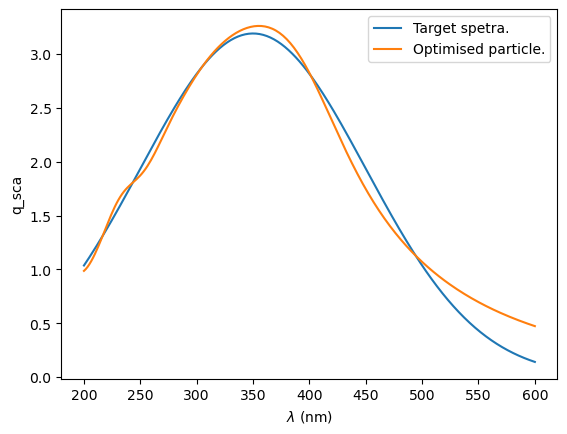

In [287]:
plt.plot(wl.detach(), target.detach(), label = "Target spetra.")
plt.plot(wl.detach(), iteration_n.detach(), label = "Optimised particle.")
plt.xlabel("$\lambda$ (nm)")
plt.ylabel(optim_expression)
plt.legend()
plt.show()

### Plot the loss curve.

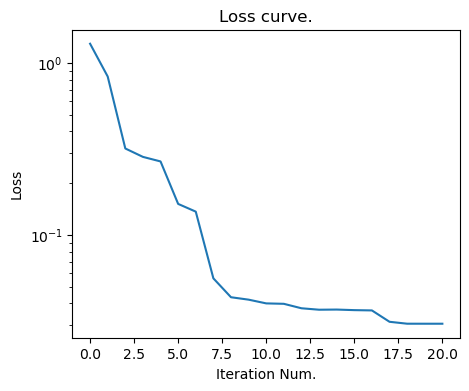

In [288]:
plt.figure(figsize=(5, 4))
plt.subplot(title="Loss curve.")
plt.plot(losses)
plt.xlabel("Iteration Num.")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()
